In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

M_Z = 91.187  # mass of Z boson (GeV)

In [2]:
dataset = pd.read_csv("./data/SM_10k.csv")
# Apply cuts
df = dataset[
    (abs(dataset["m_ll"] - M_Z) < 15)
    & (dataset["m_jj"] > 300)
    & (abs(dataset["delta_eta_jj"]) > 2.5)
]

df.count()

m_ll            6983
m_jj            6983
pt_l1           6983
pt_l2           6983
pt_j1           6983
pt_j2           6983
pt_ll           6983
eta_l1          6983
eta_l2          6983
eta_j1          6983
eta_j2          6983
delta_eta_jj    6983
delta_phi_jj    6983
dtype: int64

In [3]:
df.head()

,m_ll,m_jj,pt_l1,pt_l2,pt_j1,pt_j2,pt_ll,eta_l1,eta_l2,eta_j1,eta_j2,delta_eta_jj,delta_phi_jj
0,91.635210,667.722780,76.915838,70.168638,79.861451,114.119794,116.217132,1.229191,1.006156,3.575737,-0.300728,3.876465,-1.900115
1,96.278517,2420.868329,122.669099,33.745498,208.670392,330.818190,145.454612,0.829505,1.967168,2.528491,-1.890051,4.418542,-2.839869
2,93.136842,1354.262005,24.359742,101.941891,94.105585,64.554857,85.313150,-0.216607,-0.199792,-1.593260,4.113683,-5.706943,2.063296
4,89.975393,540.147829,68.022582,49.693719,172.316059,118.034701,93.485945,0.126138,1.033327,-0.842621,1.687083,-2.529704,2.601356
5,91.617452,308.289170,22.777012,104.058939,59.672914,95.618096,106.870125,1.180797,-0.002955,-2.260247,0.535280,-2.795527,1.683416


In [4]:
# select variables
selection = [
    "m_ll",
    "m_jj",
    "pt_l1",
    "pt_l2",
    "pt_j1",
    "pt_j2",
    "pt_ll",
    "eta_l1",
    "eta_l2",
    "eta_j1",
    "eta_j2",
    "delta_eta_jj",
    "delta_phi_jj",
]
df = df[selection]
for vars in ["m_ll", "m_jj", "pt_l1", "pt_l2", "pt_j1", "pt_j2", "pt_ll"]:
    df[vars] = df[vars].apply(np.log10)

In [5]:
X_train, X_test = train_test_split(df, test_size=0.2)

In [6]:
# MinMax scaling
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

In [7]:
# create train and test dataloaders
batch_size = 10
train_loader = DataLoader(dataset=X_train, batch_size=batch_size)
test_loader = DataLoader(dataset=X_test, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
class VAE(nn.Module):

    def __init__(self, input_dim=13, hidden_dim=20, latent_dim=7):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2),
        )

        # latent mu and variance
        self.mu_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )

    def encode(self, x):
        x = self.encoder(x)
        mu, logvar = self.mu_layer(x), self.logvar_layer(x)
        return mu, logvar

    def reparameterization(self, mu, std):
        epsilon = torch.randn_like(std).to(device)
        z = mu + std * epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        std = (0.5 * logvar).exp()
        z = self.reparameterization(mu, std)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

In [9]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


def loss_function(x, x_hat, mu, logvar):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return reproduction_loss + KLD

In [10]:
def train(epochs):
    model.train()
    losses = []
    for e in range(epochs):
        print(f"=== EPOCH {e} ===")
        epoch_loss = 0
        for idx, x in enumerate(train_loader):
            x = x.float().to(device)
            optimizer.zero_grad()

            x_hat, mean, log_var = model.forward(x)
            loss = loss_function(x, x_hat, mean, log_var)

            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()
        losses.append(epoch_loss)
        print(f"AVG LOSS : {epoch_loss/(idx*batch_size)}")

    return losses

In [11]:
epochs = 10
train(epochs)

=== EPOCH 0 ===
AVG LOSS : 8.883698548210992
=== EPOCH 1 ===
AVG LOSS : 8.858823464506417
=== EPOCH 2 ===
AVG LOSS : 8.858584801868727
=== EPOCH 3 ===
AVG LOSS : 8.858398485354625
=== EPOCH 4 ===
AVG LOSS : 8.858001328881924
=== EPOCH 5 ===
AVG LOSS : 8.858263825173873
=== EPOCH 6 ===
AVG LOSS : 8.858032420031913
=== EPOCH 7 ===
AVG LOSS : 8.857852415542876
=== EPOCH 8 ===
AVG LOSS : 8.857964981243175
=== EPOCH 9 ===
AVG LOSS : 8.858027637303943


[49571.037899017334,
 49432.2349319458,
 49430.90319442749,
 49429.86354827881,
 49427.64741516113,
 49429.112144470215,
 49427.820903778076,
 49426.81647872925,
 49427.444595336914,
 49427.794216156006]

In [12]:
def test():
    model.eval()
    loss = 0
    for idx, x in enumerate(test_loader):
        x = x.float().to(device)

        x_hat, mean, log_var = model.forward(x)
        loss = loss_function(x, x_hat, mean, log_var)

        loss += loss.item()

        print(f"AVG LOSS : {loss/(idx*batch_size)}")

    return

In [22]:
model.eval()
T_test = torch.from_numpy(X_test).float().to(device)
print(T_test)
X_hat, mean, log_var = model.forward(T_test)
X_hat = X_hat.detach().cpu()
print(T_test.size(), X_hat.size())

tensor([[0.5619, 0.1959, 0.4974,  ..., 0.4489, 0.6519, 0.2646],
        [0.5281, 0.1612, 0.4880,  ..., 0.2377, 0.6732, 0.7110],
        [0.5453, 0.2986, 0.6199,  ..., 0.1704, 0.7096, 0.2933],
        ...,
        [0.5437, 0.2539, 0.4024,  ..., 0.5733, 0.2796, 0.7134],
        [0.9743, 0.4699, 0.3738,  ..., 0.8389, 0.2528, 0.4351],
        [0.5513, 0.3689, 0.3160,  ..., 0.2658, 0.6642, 0.7434]],
       device='cuda:0')
torch.Size([1397, 13]) torch.Size([1397, 13])


(array([  1.,   3.,   1.,   1.,   2.,   6.,   5.,  10.,   6.,  18.,  21.,
         28.,  29.,  38.,  47., 157., 233., 334., 109.,  77.,  66.,  52.,
         44.,  21.,  29.,  13.,  18.,   7.,  13.,   3.,   2.,   2.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.39617044, 0.39676881, 0.39736721, 0.39796558, 0.39856398,
        0.39916235, 0.39976072, 0.40035912, 0.40095749, 0.40155587,
        0.40215427, 0.40275264, 0.40335101, 0.40394941, 0.40454778,
        0.40514618, 0.40574455, 0.40634292, 0.40694132, 0.4075397 ,
        0.4081381 , 0.40873647, 0.40933484, 0.40993324, 0.41053161,
        0.41112998, 0.41172838, 0.41232675, 0.41292512, 0.41352352,
        0.4141219 , 0.4147203 , 0.41531867, 0.41591704, 0.41651544,
        0.41711381, 0.41771221, 0.41831058, 0.41890895, 0.41950735,
        0.42010573]),
 <BarContainer object of 40 artists>)

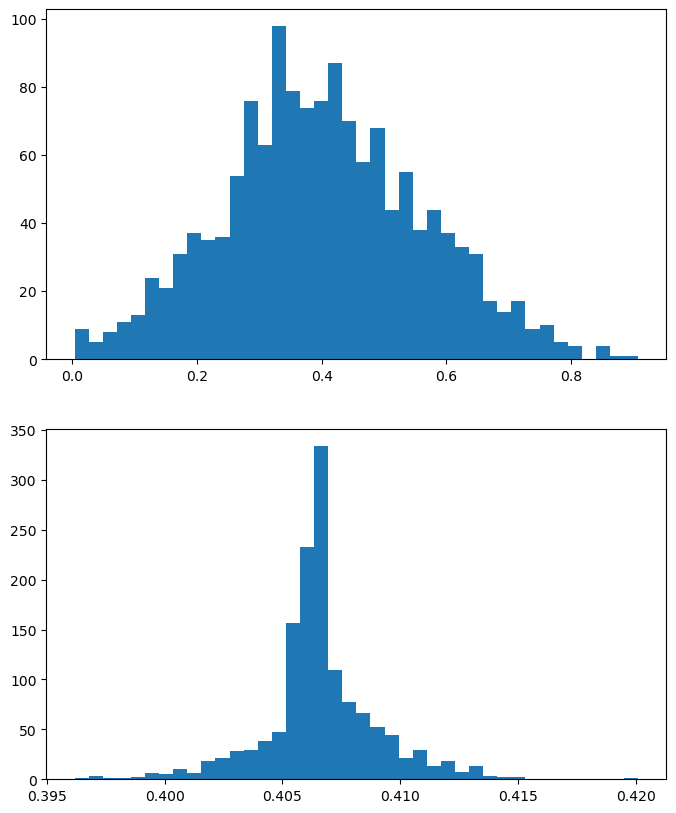

In [20]:
n_bins = 40
fig, ax = plt.subplots(2, 1, figsize=(8, 10))
ax[0].hist(X_test[:, 3], bins=n_bins)
ax[1].hist(X_hat[:, 3], bins=n_bins)